In [1]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Importing and preprocessing.

# Convert to RGB since the alpha channel is not needed.
image = Image.open('test_img.png').convert('RGB')
data = np.asarray(image)


def corrupt(arr, degree=55):
    # Introduce black pixel noise.

    # Flattening 1 dim = list of all pixels in img.
    arr1 = arr.copy()
    dim_reduced = arr1.reshape(-1, *arr1.shape[-1:])
    ind = np.arange(dim_reduced.shape[0], dtype='int')

    # Number of pixels to corrupt.
    n = int(dim_reduced.shape[0] * degree * 10**-2)

    rand = np.random.choice(ind, n, replace=False)

    # Blacking-out random pixels.
    for i in range(len(rand)):
        dim_reduced[rand[i]] = np.array([0,0,0])

    # Expand noisy arr to dims of arr.
    return dim_reduced.reshape(arr1.shape[0], arr1.shape[1],3)


def greyscale(arr):
    # Accepted formula of Timothy Sauer for RGB to greyscale conversion.
    # Sets 0 to black. 
    grey = np.zeros((arr.shape[0], arr.shape[1]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            grey[i,j] = 0.2126*arr[i,j,0] + 0.7152*arr[i,j,1] + 0.0722*arr[i,j,2]
            
    return np.uint8(grey)




# Introduce noise:
# noisy = corrupt(data)
# Image.fromarray(noisy)

## Algorithm 1: Single Value Decompostion for Reconstruction (SVD)


Using "Numerical Analysis 2E" by Timothy Sauer.

*We will stick to square images in this treatment, as they allow us to take advantage of a computationally efficient approach to calculating SVDs.*

---

#### Steps for SVD:

A singular value decomposition for some $m\times m$ matrix A, $m\in \mathbb{N}$ takes the form $$A = U S V^T,$$ where $U$ is an $m\times m$ matrix whose columns are the **left singular** vectors, $u_i$, and $V$ is an $m\times m$ matrix whose columns are the **right singular** vectors, $v_i$. $S$ is, therefore, the diagonal $m\times m$ matrix whose diagonal entries are the singular values $s_i$ of $A$. To perform SVD, one need identify $U$, $V$, and $S$.

1. $U$ is found simply by computing the eigenvalues, $\lambda_i$, and eignvectors, $\beta_i$, of the matrix product $A^T A$. With the $\|\lambda_i\|$ -- and consequently, the $\beta_i$ -- aranged in descending order of size, we make the correspondance $v_i == \beta_i$ so tha we have the column vector representation $$ V = [\beta_1  \ \beta_2 \ \cdots \ \beta_m ].$$

2. Maintaining the ordering of the $\lambda_i$, we then have the correspondance $s_i == \sqrt{\lambda_i}$ with 
$$ S = \left[\begin{array}
{rrrr}
\sqrt{\lambda_1} & 0 & \cdots & 0 \\
0 & \sqrt{\lambda_2} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & \cdots & \cdots & \sqrt{\lambda_m} \\
\end{array}\right].
$$

3. Lastly, using the definition of the SVD, $s_i u_i = A v_i$, composition of the $u_i$ follow as $u_i = \frac{1}{s_i} A v_i$ so that $$ U = [u_1  \ u_2 \ \cdots \ u_m ].$$


---

- Weakness of this approach is that unless you know the SVD for an image before it is corrupted, there is no way to recover lost information with this method.

- On the other hand, this algorithm works well for compression.

In [26]:
# Basic SVD implementation.
# Check on later. for now, Just use numpy.

def svd(mat):
    # SV decomp of an mxm matrix.
    eigVal, eigVec = np.linalg.eig(np.matmul(np.transpose(mat), mat))
    
    # Sorting largest to smallest, simultaneously preserving order of values and vectors.
    idx = eigVal.argsort()[::-1]
    eigVal = eigVal[idx]
    eigVec = eigVec[:,idx]

    leftSingular = eigVec.transpose()
    singular = np.diag(np.sqrt(eigVal))

    # Cannot do matrix mult since mat cannot be assumed invertible.
    rightSingular = np.zeros((mat.shape[0], mat.shape[1]))
    for i in range(mat.shape[0]):
        rightSingular[:,i] = (1/singular[i,i]) * np.matmul(mat, leftSingular[:,i])

    return leftSingular, singular, rightSingular


def svd_reconstruction(mat, p=1, verbose=False):
    # Reconstruct noisy image using SVD rank-p summation approximation.
   
    # Numpy's proprietary SVD routine. v = v^T by default.
    u, s, v = linalg.svd(mat, full_matrices=False)
    var = np.round(s**2/np.sum(s**2), decimals=6)
    
    if verbose: 
        print(f'Varience explained by first 20 singular values:\n{var[:20]}')
        
        plt.bar(np.arange(1, 21, 1), var[:20], color="red")
        plt.xlabel('Singular Vector', fontsize=12)
        plt.ylabel('Variance Explained', fontsize=12)
        plt.savefig('svdVariance.png',dpi=100)

    if (p > mat.shape[1]): p = mat.shape[1]
    
    # Using the first p singular values to compute A=USV^T. 
    return np.matmul(u[:, :p], np.matmul(np.diag(s[:p]), v[:p, :])) 

Varience explained by first 20 singular values:
[9.72561e-01 1.01320e-02 3.93800e-03 2.95500e-03 1.44600e-03 1.29800e-03
 8.04000e-04 7.70000e-04 6.85000e-04 5.51000e-04 4.01000e-04 3.15000e-04
 2.94000e-04 2.56000e-04 2.25000e-04 2.06000e-04 1.87000e-04 1.59000e-04
 1.37000e-04 1.32000e-04]


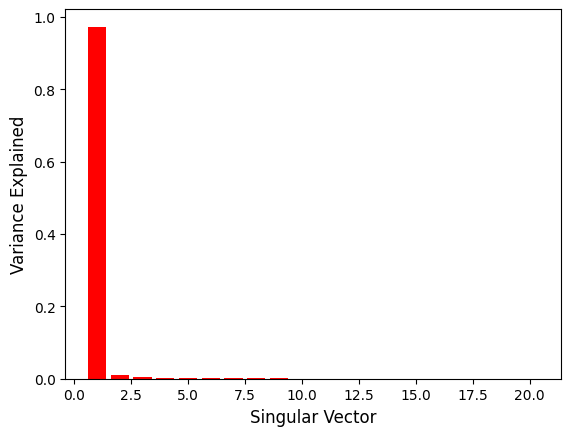

In [27]:
# Example using the Duolingo Test image:

# Currently only able to use greyscale at this time, so we convert.
# greyed = greyscale(data)
x = svd_reconstruction(greyed, p=1555, verbose=True)

## Mean Value Overwriting

Using mean values of neighboring pixels to make a guess at the value of lost pixels.

--- 

Assume
1. A noise pixel is pure black (RGB = [0,0,0] or greyscale 0 since we center our color at 0) with no more than 2 of its 8 nearest neighbors also black.
2. We only deal with greyscale images. (RGB presents 3-fold advantage in correctly detecting a "noise pixel" due to the two added color channels, so this will be addressed later.)

In [30]:
corrupt = greyscale(corrupt(data))

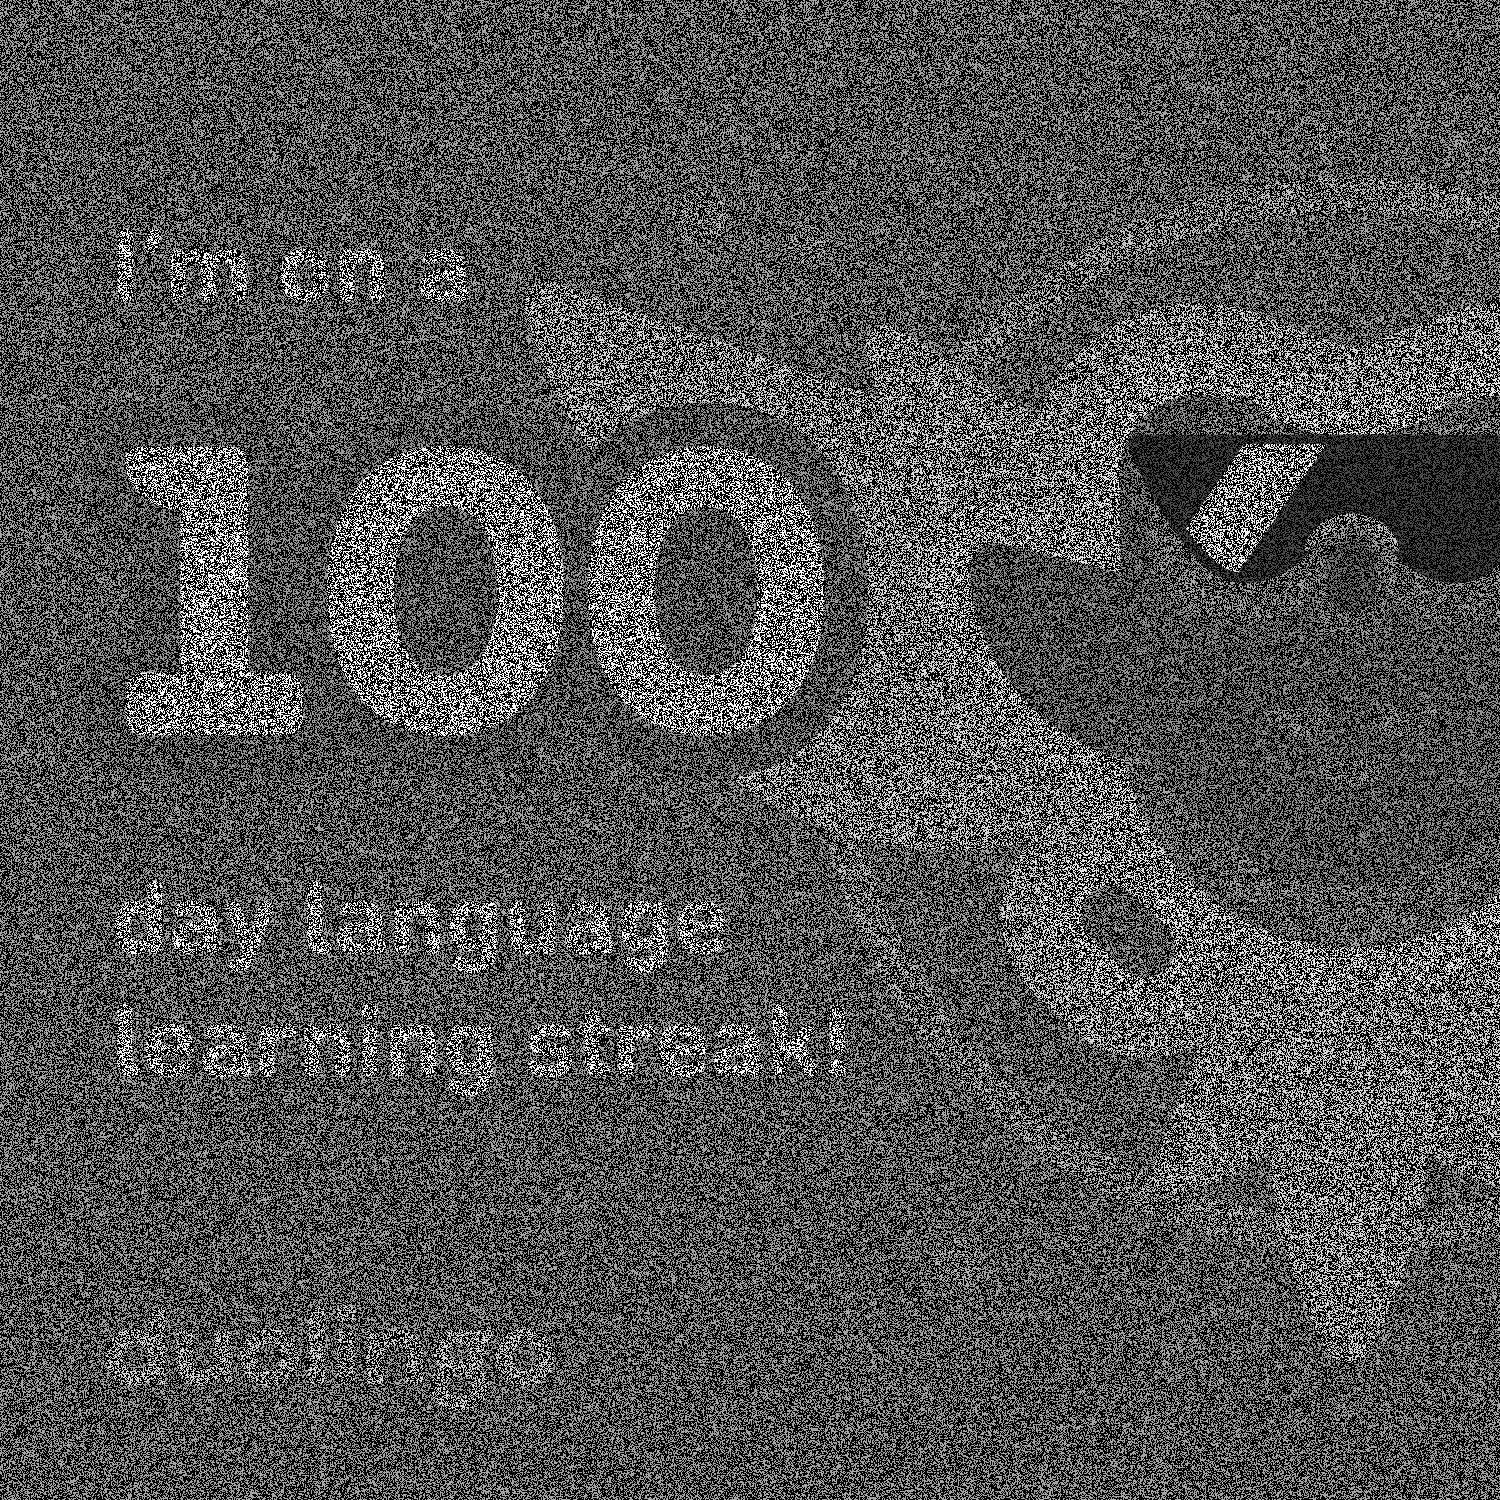

In [33]:
Image.fromarray(corrupt)

In [34]:
def localMean(mat, x, y, degree=1):
    # Computes avg of a matrix element's nearest neighbors.
    # Takes matrix, element indicies (x,y), and degree (layers of averaging).

    if x>0:
        if y>0:
            sum = mat[x-1,y-1] + mat[x,y-1] + mat[x+1,y-1]
        
        else:
            

    return mean

def detectNoise(mat, generations = 1):
    # Identify noise (pure black pixels) in greyscale image array. 
    # Returns ndarray of pointers to suspected noisy pixels.

    for i in range(mat.shape[0]):
        for j in range((mat.shape[1])):
            # Notes greyscale 0 is black.
            if (mat[i,j] = 0):
                mat[i,j] = localMean(mat, i, j)


    return #ndarray

SyntaxError: invalid syntax (3351304302.py, line 6)

## Algorithm 1: Simultaneous Normalized Hard Thresholding (SIHT/SNIHT)


Reproduced from "Greedy Algorithms in Image Reconstruction" (Blanchard, Cermak, Hanle, Jing, 2014)

In [ ]:
# pseudo:

for j in range(0, stop):
    if(SIHT):
        w[j] = w
    elif (SNIHT):
        w[j] = l2 norm of matrices on line 5
    if (conditions of line 7-10):
        break

    return local matrix X

In [ ]:
# SIHT/SNIHT algorithm:

